## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras


# 本範例不需使用 GPU, 將 GPU 設定為 "無"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config)) 

Using TensorFlow backend.
C:\Users\cerbe\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\cerbe\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\cerbe\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\cerbe\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.3]
redice_lr_patient = [8, 3]


In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("%s-factor-%f-patient-%f" % (i, reduce_factor, reduce_patient))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 8




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normaliz

Epoch 3/25
50000/50000 [==============================] - 1s 30us/step - loss: 1.6493 - acc: 0.4241 - val_loss: 1.7233 - val_acc: 0.4011
Epoch 4/25
50000/50000 [==============================] - 1s 29us/step - loss: 1.5744 - acc: 0.4510 - val_loss: 1.6414 - val_acc: 0.4256
Epoch 5/25
50000/50000 [==============================] - 1s 29us/step - loss: 1.5221 - acc: 0.4679 - val_loss: 1.6078 - val_acc: 0.4358
Epoch 6/25
50000/50000 [==============================] - 1s 29us/step - loss: 1.4773 - acc: 0.4847 - val_loss: 1.5941 - val_acc: 0.4431
Epoch 7/25
50000/50000 [==============================] - 1s 29us/step - loss: 1.4432 - acc: 0.4958 - val_loss: 1.5595 - val_acc: 0.4547
Epoch 8/25
50000/50000 [==============================] - 1s 29us/step - loss: 1.4091 - acc: 0.5069 - val_loss: 1.5476 - val_acc: 0.4563
Epoch 9/25
50000/50000 [==============================] - 1s 29us/step - loss: 1.3787 - acc: 0.5176 - val_loss: 1.5175 - val_acc: 0.4683
Epoch 10/25
50000/50000 [================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 2s 42us/step - loss: 2.2526 - acc: 0.2595 - val_loss: 2.2514 - val_acc: 0.2954
Epoch 2/25
50000/50000 [==============================] - 1s 29us/step - loss: 1.7756 - acc: 0.3855 - val_loss: 1.8300 - val_acc: 0.3771
Epoch 3/25
50000/50000 [==============================] - 1s 29us/step - loss: 1.6464 - acc: 0.4222 - val_loss: 1.7681 - val_acc: 0.3853
Epoch 4/25
50000/50000 [==============================] - 1s 29us/step - loss: 1.5733 - acc: 0.4476 - val_loss: 1.6462 - val_acc: 0.4253
Epoch 5/25
50000/50000 [==============================] - 1s 29us/step - loss: 1.5188 - acc: 0.4676 - val_loss: 1.6037 - val_acc: 0.4425
Epoch 6/25
50000/50000 [==============================] - 1s 29us/step - loss: 1.4747 - acc: 0.4847 - val_loss: 1.5779 - val_acc: 0.4470
Epoch 7/25
50000/50000 [==============================] - 1s 30us/step - loss: 1.4384 - acc: 0.4982 - val_loss: 1.5596 - val_acc

50000/50000 [==============================] - 2s 30us/step - loss: 0.3693 - acc: 0.8918 - val_loss: 1.7226 - val_acc: 0.5032
Epoch 24/25
50000/50000 [==============================] - 2s 30us/step - loss: 0.3414 - acc: 0.9032 - val_loss: 1.9473 - val_acc: 0.4830
Epoch 25/25
50000/50000 [==============================] - 1s 30us/step - loss: 0.3211 - acc: 0.9084 - val_loss: 1.8832 - val_acc: 0.4987
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer

50000/50000 [==============================] - 2s 31us/step - loss: 1.4030 - acc: 0.5067 - val_loss: 1.5412 - val_acc: 0.4508
Epoch 7/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.3707 - acc: 0.5194 - val_loss: 1.5333 - val_acc: 0.4589
Epoch 8/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.3422 - acc: 0.5288 - val_loss: 1.5264 - val_acc: 0.4662
Epoch 9/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.3161 - acc: 0.5401 - val_loss: 1.5098 - val_acc: 0.4673
Epoch 10/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.2934 - acc: 0.5480 - val_loss: 1.4957 - val_acc: 0.4756
Epoch 11/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.2720 - acc: 0.5574 - val_loss: 1.4869 - val_acc: 0.4790
Epoch 12/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.2532 - acc: 0.5624 - val_loss: 1.4681 - val_acc: 0.4855
Epoch 13/25
50000/50000 [========================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.8418 - acc: 0.3677 - val_loss: 3.5643 - val_acc: 0.2050
Epoch 2/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.5327 - acc: 0.4562 - val_loss: 1.8621 - val_acc: 0.3609
Epoch 3/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.4204 - acc: 0.4962 - val_loss: 2.1642 - val_acc: 0.3175
Epoch 4/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.3388 - acc: 0.5278 - val_loss: 2.0685 - val_acc: 0.3424
Epoch 5/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.2693 - acc: 0.5518 - val_loss: 2.1378 - val_acc: 0.3116
Epoch 6/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.2226 - acc: 0.5682 - val_loss: 2.0375 - val_acc: 0.3303
Epoch 7/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.1691 - acc: 0.5890 - val_loss: 1.8965 - val_acc

Epoch 22/25
50000/50000 [==============================] - 2s 30us/step - loss: 0.5587 - acc: 0.8217 - val_loss: 1.4509 - val_acc: 0.5293
Epoch 23/25
50000/50000 [==============================] - 1s 30us/step - loss: 0.5368 - acc: 0.8312 - val_loss: 1.5206 - val_acc: 0.5205
Epoch 24/25
48128/50000 [===========================>..] - ETA: 0s - loss: 0.5189 - acc: 0.8353
Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
50000/50000 [==============================] - 1s 30us/step - loss: 0.5203 - acc: 0.8343 - val_loss: 1.5133 - val_acc: 0.5173
Epoch 25/25
50000/50000 [==============================] - 1s 30us/step - loss: 0.4821 - acc: 0.8535 - val_loss: 1.4933 - val_acc: 0.5333
Numbers of exp: 10, reduce_factor: 0.30, reduce_patient: 8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
___________________________

50000/50000 [==============================] - 1s 30us/step - loss: 1.2412 - acc: 0.5680 - val_loss: 1.5448 - val_acc: 0.4622
Epoch 9/25
50000/50000 [==============================] - 1s 30us/step - loss: 1.2076 - acc: 0.5805 - val_loss: 1.5683 - val_acc: 0.4550
Epoch 10/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.1747 - acc: 0.5948 - val_loss: 1.5491 - val_acc: 0.4608
Epoch 11/25
50000/50000 [==============================] - 1s 30us/step - loss: 1.1428 - acc: 0.6042 - val_loss: 1.5425 - val_acc: 0.4589
Epoch 12/25
50000/50000 [==============================] - 1s 30us/step - loss: 1.1125 - acc: 0.6163 - val_loss: 1.4810 - val_acc: 0.4857
Epoch 13/25
50000/50000 [==============================] - 1s 30us/step - loss: 1.0841 - acc: 0.6286 - val_loss: 1.4781 - val_acc: 0.4888
Epoch 14/25
50000/50000 [==============================] - 1s 30us/step - loss: 1.0600 - acc: 0.6375 - val_loss: 1.4823 - val_acc: 0.4813
Epoch 15/25
50000/50000 [======================

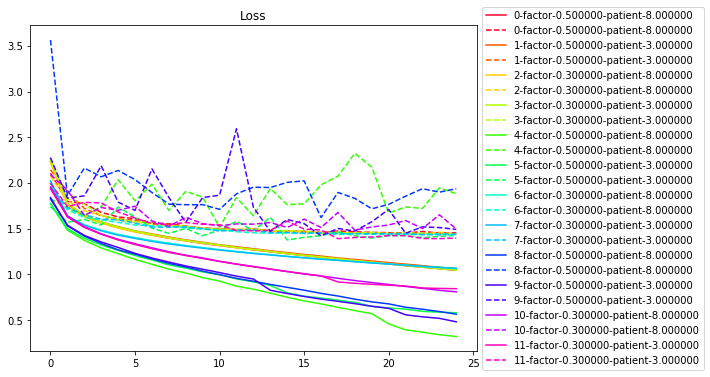

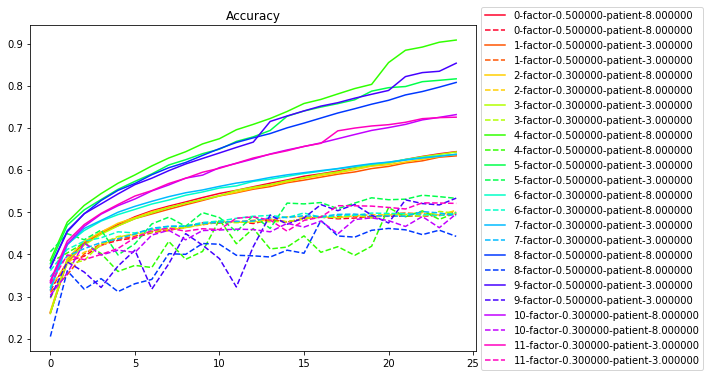

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

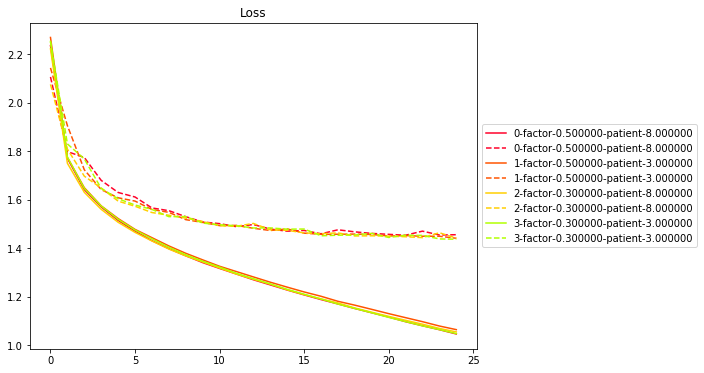

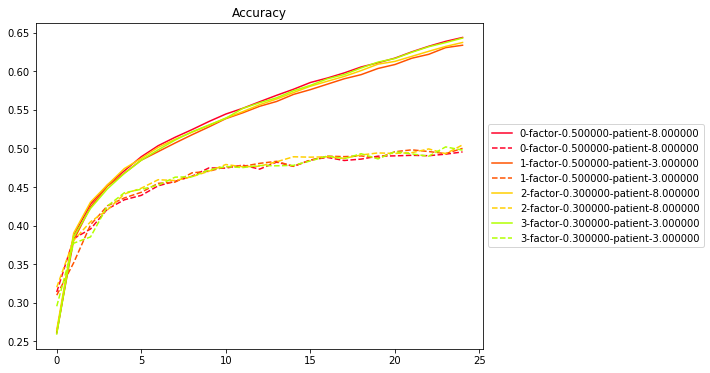

In [11]:
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    if i in [0,1,2,3]:
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    if i in [0,1,2,3]:
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

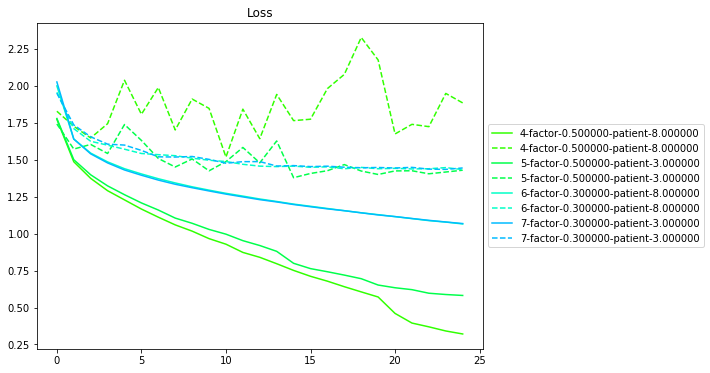

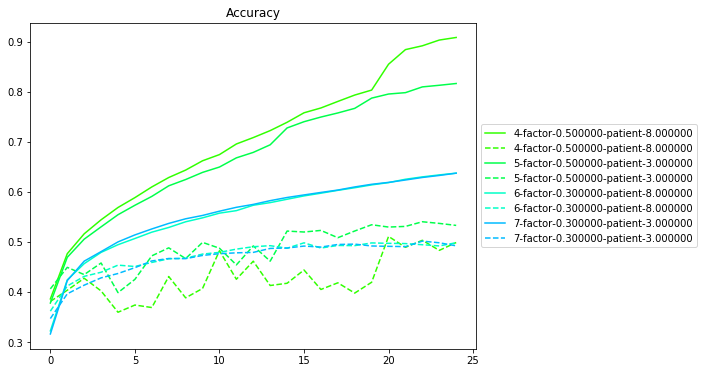

In [15]:
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    if i in [4,5,6,7]:
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    if i in [4,5,6,7]:
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

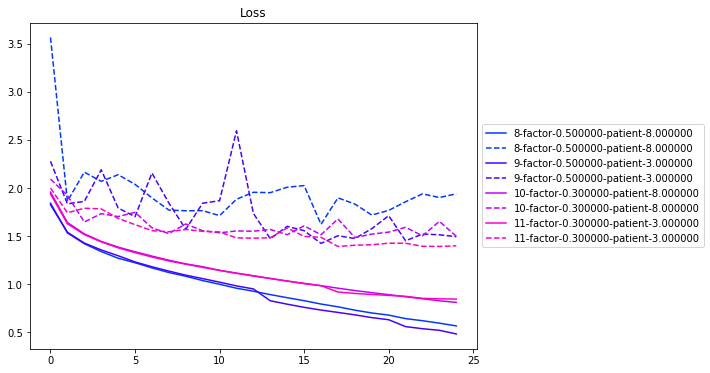

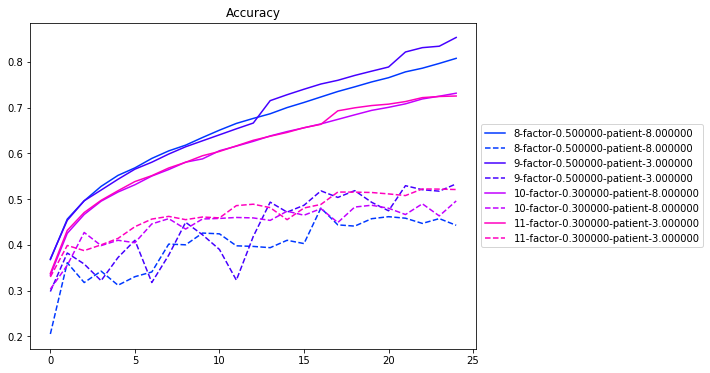

In [14]:
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    if i in [8,9,10,11]:
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    if i in [8,9,10,11]:
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()